# Beta-binomial regression

The good shooters also typically tend to take a lot more shots. So, there is a relation between volume of shots and shot conversion rate. Which means the previous calculations have a systematic flaw - can't use the same priors for everyone. We will fix that with a beta-binomial regression. We are also going to a bit stricter with our cutoffs - we will only select players with atleast 50 shots

In [1]:
%load_ext autoreload
%autoreload 2

import scipy.special as special
from scipy.stats import beta,binom,chi2_contingency,gaussian_kde,rv_continuous,norm,rv_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import numpy.typing as npt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 50)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])
df['a'] = df['npG'] + bf[0]
df['b'] = df['Shots'] + bf[1] - df['npG']
df.rename(columns = {'90s':'Nineties'},inplace=True)

Let's plot the raw shot conversion rate to the number of shots and fit a linear model to the data and plot out the line. We will also reparametrize the Beta distribution into a form that God intended to : rewrite the parameters $\alpha$ and $\beta$ in terms of the mean $\mu$ and standard deviation $\sigma$ of the data thus giving us 

$$
Beta \equiv Beta\left(\frac{\mu}{\sigma}, \frac{1-\mu}{\sigma}\right)
$$

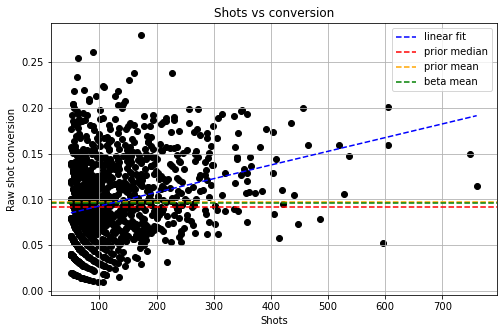

In [2]:
x = (df.Shots.values.reshape(-1,1))
y = (df.Conv.values)
model = LinearRegression().fit(x, y)
intc, slope = model.intercept_, model.coef_
X = np.linspace(df.Shots.min(), df.Shots.max(), 100)
Y = slope*(X) + intc
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(df.Shots, df.Conv, color='k')
ax.plot(X, (Y), color = 'b', ls='--',zorder=3, label='linear fit')
ax.axhline(df.Conv.median(), color='r', ls = '--', zorder=2, label = 'prior median')
ax.axhline(df.Conv.mean(), color='orange', ls = '--', zorder=2, label = 'prior mean')
ax.axhline(bf[0]/(bf[0] + bf[1]), color='green', ls = '--', zorder=2, label = 'beta mean')
ax.set_xlabel('Shots')
ax.set_ylabel('Raw shot conversion')
ax.set_title('Shots vs conversion')
ax.grid();
ax.legend();
# ax.set_yscale('log');

So, there are two trends here. For small volume of shots, the variance is high. At the same time, the conversion rate shows a slight upwards trend as volume of shots increase. Granted, it's a very weak effect. Let's still try to capture this effect. One way to do this will be to assign different priors to each player instead of using a single prior. We will hold $\sigma$ fixed and let $\mu$ vary linearly with number of shots

$$
\mu_i = \mu_0 + \mu_{v} N_i
$$

where $N_{i}$ is the number of shots by the i-th player. Since linear regression can allow values to go negative while $\mu_i$ should be between 0 and 1, we will also use the inverse logit, or expit function as the link function for the regression. Once we have determined $\mu_0$,$\sigma_0$ and $\mu_v$ by performing a beta-binomial regression and $\mu_i$ from the parameters and $N_i$, we can easily determine the parameters $\alpha_i = \mu_i/\sigma_0$ and $\beta_i = (1 - \mu_i)/\sigma_0$ for the posterior.

In [3]:
def BBLL1(params,Y,N):
    mu0, mu1, phi = params
    mu = special.expit(mu0 + mu1*N) #1.0/(1.0 + np.exp(-mu0 - mu1*N))
    a = mu*phi
    b = (1-mu)*phi
    t1 = special.loggamma(N+1+1e-15) - special.loggamma(Y+1+1e-15) - special.loggamma(N-Y+1+1e-15)  
    t2 = special.loggamma(Y+a+1e-15) + special.loggamma(N-Y+b+1e-15) - special.loggamma(N+a+b+1e-15)
    t3 = special.loggamma(a+b+1e-15) - special.loggamma(a+1e-15) - special.loggamma(b+1e-15)
    total = -np.sum(t1 + t2 + t3)
    return total
res = minimize(BBLL1, x0=[0,0,100], args=(df.npG.values,df.Shots.values),
               bounds=[(None,None),(None,None),(0,None)])
mu0, mu1 = res.x[:-1]
sigma0 = 1/res.x[-1]

In [4]:
df['new_a'] = special.expit(mu0 + mu1*df.Shots)/sigma0 + df['npG']
df['new_b'] = (1 - special.expit(mu0 + mu1*df.Shots))/sigma0 + df['Shots'] - df['npG']
df['new_Conv'] = df['new_a']/(df['new_a'] + df['new_b'])
df.head()

,Player,Nineties,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv,a,b,new_a,new_b,new_Conv
0,Aaron Connolly (2000),24.5,5.0,63.0,0.0,7.2,5.0,2000.0,21.0,0.079365,0.085850,8.66804,92.298986,13.920665,149.054962,0.085416
1,Aaron Cresswell (1989),130.0,5.0,78.0,0.0,3.9,5.0,1989.0,32.0,0.064103,0.074746,8.66804,107.298986,14.086968,163.888659,0.079151
2,Aaron Leya Iseka (1997),35.8,10.0,73.0,3.0,10.0,7.0,1997.0,24.0,0.095890,0.096137,10.66804,100.298986,16.031226,156.944401,0.092679
3,Aaron Mooy (1990),83.2,9.0,100.0,2.0,5.5,7.0,1990.0,31.0,0.070000,0.077323,10.66804,127.298986,16.335927,183.639700,0.081690
4,Aaron Ramsey (1990),60.2,16.0,139.0,0.0,17.1,16.0,1990.0,31.0,0.115108,0.111140,19.66804,157.298986,25.792328,213.183300,0.107929


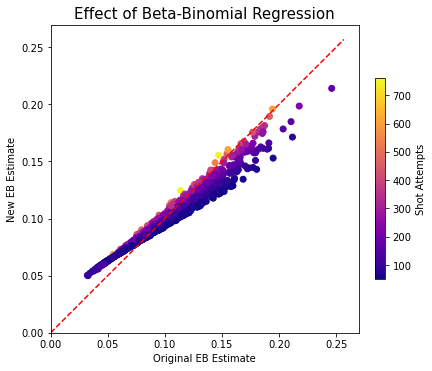

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.scatter(df.Eb_Conv, df.new_Conv, c=df.Shots, cmap=mpl.cm.plasma);
ax.plot(np.linspace(0, ax.get_xlim()[1],100), np.linspace(0, ax.get_xlim()[1],100), color='red', linestyle='--')
ax.set_aspect('equal')
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Original EB Estimate')
ax.set_ylabel('New EB Estimate')
fig.colorbar(im, ax=ax, fraction=.03).set_label('Shot Attempts');
ax.set_title('Effect of Beta-Binomial Regression', fontsize = 15);

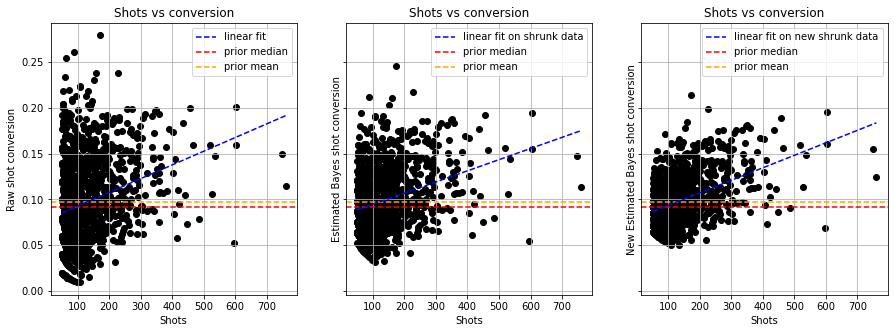

In [6]:
fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=3, sharey=True)
x = (df.Shots.values.reshape(-1,1))
y = df.Conv.values
model = LinearRegression().fit(x, y)
intc, slope = model.intercept_, model.coef_
X = np.linspace(df.Shots.min(), df.Shots.max(), 100)
Y = slope*(X) + intc
ax[0].scatter(df.Shots, df.Conv, color='k')
ax[0].plot(X, Y, color = 'b', ls='--',zorder=3, label='linear fit')
ax[0].axhline(df.Conv.median(), color='r', ls = '--', zorder=2, label = 'prior median')
ax[0].axhline(df.Conv.mean(), color='orange', ls = '--', zorder=2, label = 'prior mean')
ax[0].set_xlabel('Shots')
ax[0].set_ylabel('Raw shot conversion')
ax[0].set_title('Shots vs conversion')
ax[0].grid();
ax[0].legend();

x = (df.Shots.values.reshape(-1,1))
y = df.Eb_Conv.values
model = LinearRegression().fit(x, y)
intc, slope = model.intercept_, model.coef_
X = np.linspace(df.Shots.min(), df.Shots.max(), 100)
Y = slope*(X) + intc
ax[1].scatter(df.Shots, df.Eb_Conv, color='k')
ax[1].plot(X, Y, color = 'b', ls='--',zorder=3, label='linear fit on shrunk data')
ax[1].axhline(df.Conv.median(), color='r', ls = '--', zorder=2, label = 'prior median')
ax[1].axhline(df.Conv.mean(), color='orange', ls = '--', zorder=2, label = 'prior mean')
ax[1].set_xlabel('Shots')
ax[1].set_ylabel('Estimated Bayes shot conversion')
ax[1].set_title('Shots vs conversion')
ax[1].grid();
ax[1].legend();

x = (df.Shots.values.reshape(-1,1))
y = df.new_Conv.values
model = LinearRegression().fit(x, y)
intc, slope = model.intercept_, model.coef_
X = np.linspace(df.Shots.min(), df.Shots.max(), 100)
Y = slope*(X) + intc
ax[2].scatter(df.Shots, df.new_Conv, color='k')
ax[2].plot(X, Y, color = 'b', ls='--',zorder=3, label='linear fit on new shrunk data')
ax[2].axhline(df.Conv.median(), color='r', ls = '--', zorder=2, label = 'prior median')
ax[2].axhline(df.Conv.mean(), color='orange', ls = '--', zorder=2, label = 'prior mean')
ax[2].set_xlabel('Shots')
ax[2].set_ylabel('New Estimated Bayes shot conversion')
ax[2].set_title('Shots vs conversion')
ax[2].grid();
ax[2].legend();

There is only a tiny bit of improvement - players with fewer shots are not being too over-estimated. There is overall a bit more shrinkage of the data, and follows the trendline. But the effect isn't super strong.